## Установка зависимостей

In [12]:
!pip install opendatasets catboost optuna

## Загрузка данных

In [13]:
import opendatasets as datasets

data = datasets.download('https://www.kaggle.com/datasets/parisrohan/credit-score-classification')

Skipping, found downloaded files in "./credit-score-classification" (use force=True to force download)


## Преобразование данных

Импорт библиотеки и загрузка данных

In [14]:
import pandas as pd
df = pd.read_csv('/content/credit-score-classification/test.csv')

Преобразование возраста в месяцы

In [15]:
def convert_age_to_months(age_str):
    if pd.isnull(age_str):
        return None
    parts = age_str.split(' ')
    years = int(parts[0]) if parts[0].isdigit() else 0
    months = int(parts[3]) if len(parts) > 3 and parts[3].isdigit() else 0
    return years * 12 + months

df['Credit_History_Age_Months'] = df['Credit_History_Age'].apply(convert_age_to_months)
df = df.drop(['Credit_History_Age'], axis=1)

Преобразование месяцев и кредитного рейтинга в категориальные переменные

In [16]:
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July',
               'August', 'September', 'October', 'November', 'December']
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)
df['Month'] = df['Month'].cat.codes

credit_mix_order = ['Bad', 'Standard', 'Good']
df['Credit_Mix'] = pd.Categorical(df['Credit_Mix'], categories=credit_mix_order, ordered=True)

Преобразование данных о минимальном платеже и удаление некоторых столбцов

In [17]:
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map({'No': 0, 'Yes': 1})
df['Payment_Behaviour'] = pd.Categorical(df['Payment_Behaviour'])

df = df.drop(['ID', 'Customer_ID', 'SSN', 'Name', 'Occupation', 'Type_of_Loan', 'Payment_Behaviour'], axis=1)
cols_to_convert = ['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly', 'Monthly_Balance']

Преобразование выбранных столбцов в числовые значения

In [18]:
for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace('_', ''), errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Month                      50000 non-null  int8    
 1   Age                        50000 non-null  int64   
 2   Annual_Income              50000 non-null  float64 
 3   Monthly_Inhand_Salary      42502 non-null  float64 
 4   Num_Bank_Accounts          50000 non-null  int64   
 5   Num_Credit_Card            50000 non-null  int64   
 6   Interest_Rate              50000 non-null  int64   
 7   Num_of_Loan                50000 non-null  int64   
 8   Delay_from_due_date        50000 non-null  int64   
 9   Num_of_Delayed_Payment     46502 non-null  float64 
 10  Changed_Credit_Limit       48941 non-null  float64 
 11  Num_Credit_Inquiries       48965 non-null  float64 
 12  Credit_Mix                 40195 non-null  category
 13  Outstanding_Debt           5000

## Разведочный анализ

Импорт библиотек

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Вывод информации о данных

In [20]:
print(df.head())
print(df.info())
print(df.describe())

   Month  Age  Annual_Income  Monthly_Inhand_Salary  Num_Bank_Accounts  \
0      8   23       19114.12            1824.843333                  3   
1      9   24       19114.12            1824.843333                  3   
2     10   24       19114.12            1824.843333                  3   
3     11   24       19114.12                    NaN                  3   
4      8   28       34847.84            3037.986667                  2   

   Num_Credit_Card  Interest_Rate  Num_of_Loan  Delay_from_due_date  \
0                4              3            4                    3   
1                4              3            4                    3   
2                4              3            4                   -1   
3                4              3            4                    4   
4                4              6            1                    3   

   Num_of_Delayed_Payment  Changed_Credit_Limit  Num_Credit_Inquiries  \
0                     7.0                 11.27        

Гистограммы для всех столбцов

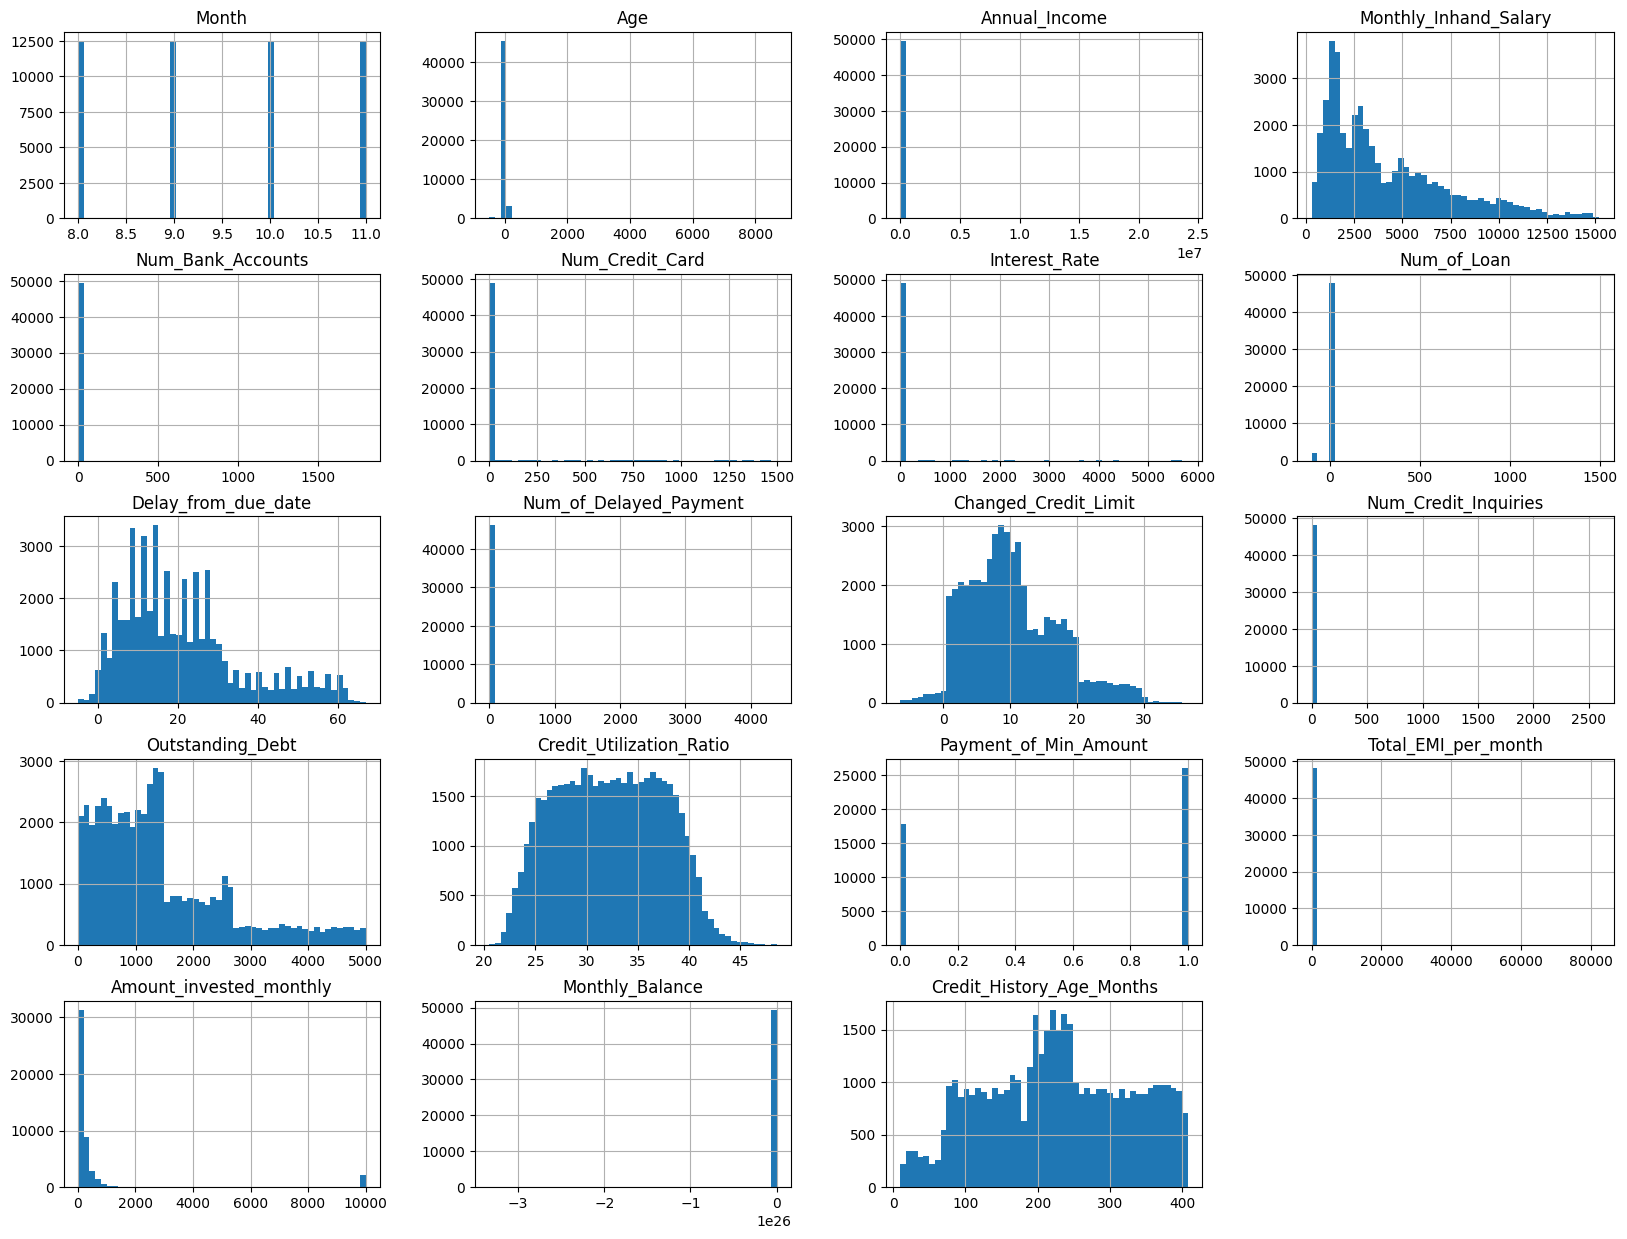

In [21]:
df.hist(bins=50, figsize=(20,15))
plt.show()

Boxplot для числовых столбцов

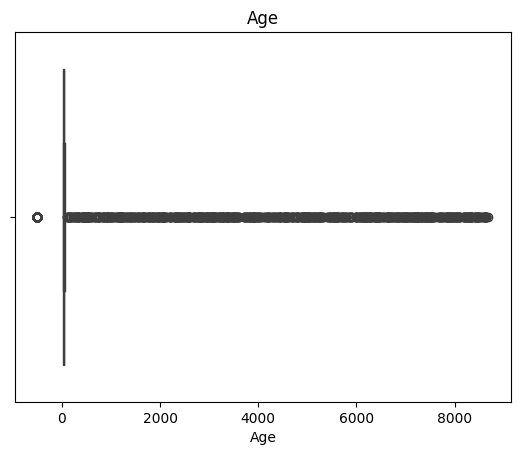

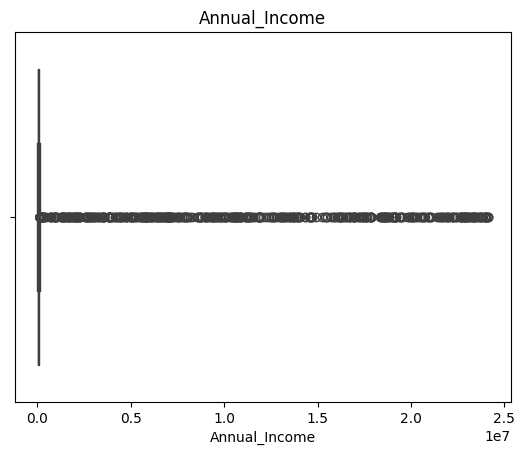

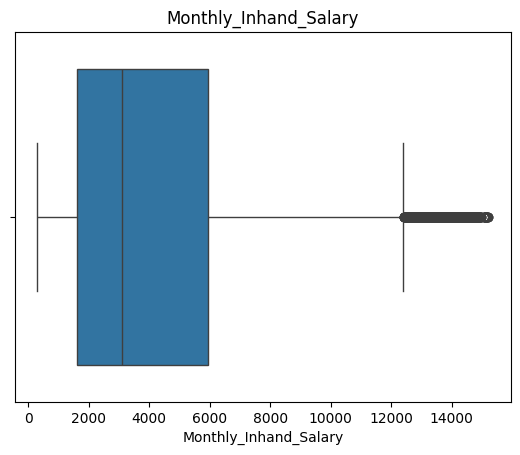

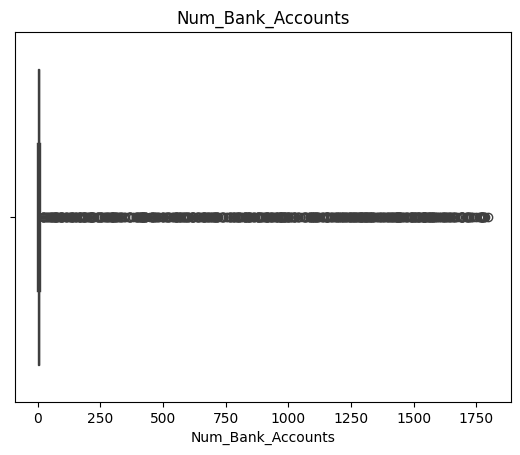

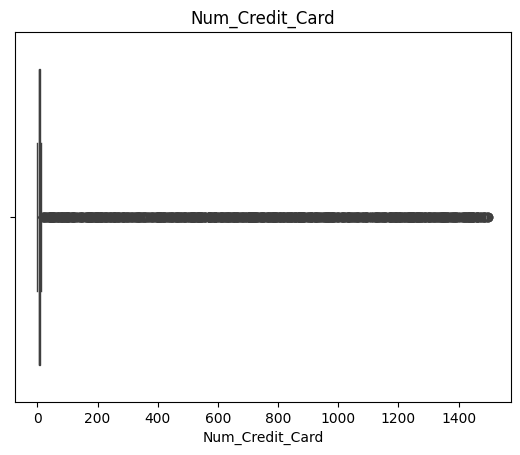

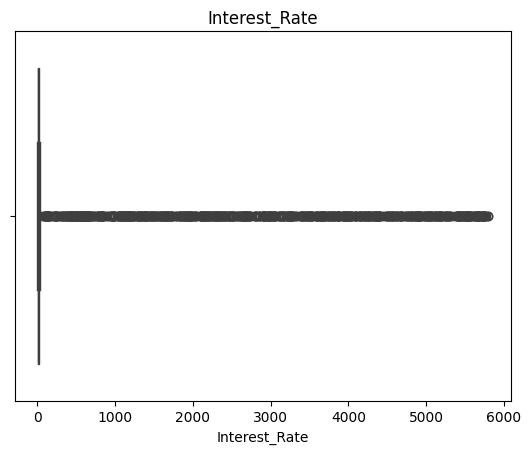

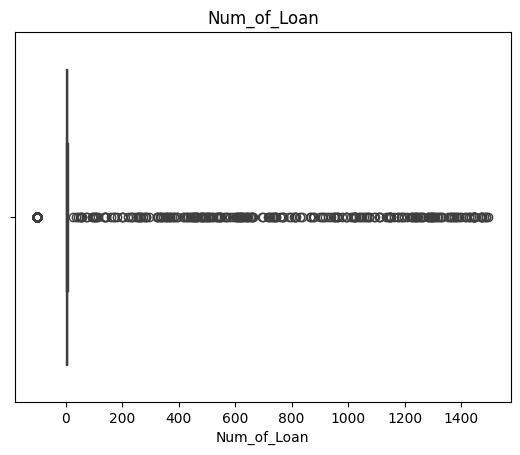

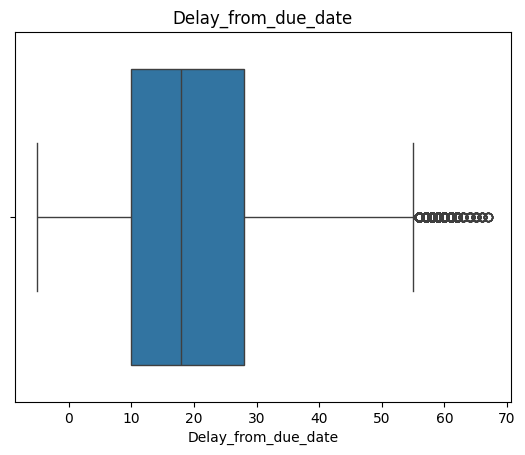

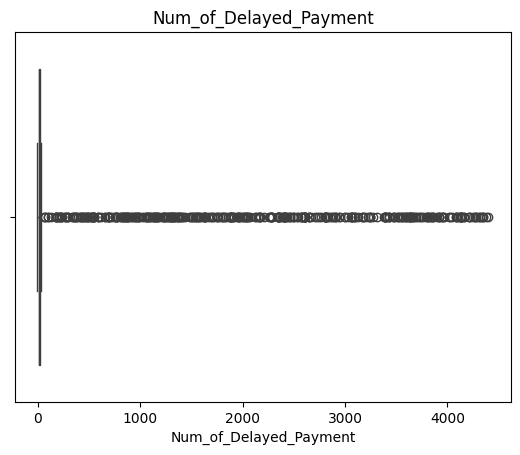

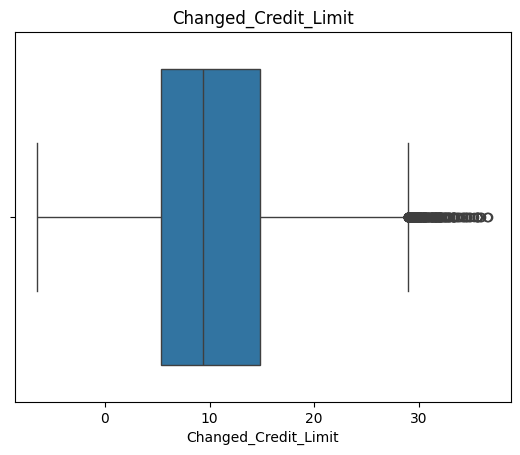

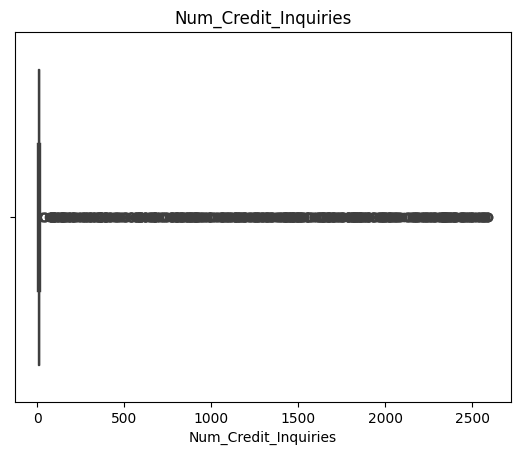

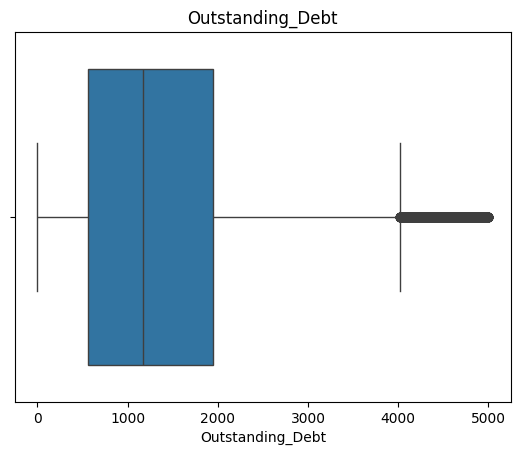

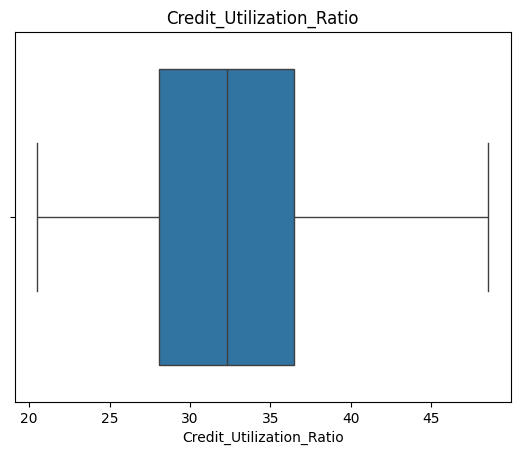

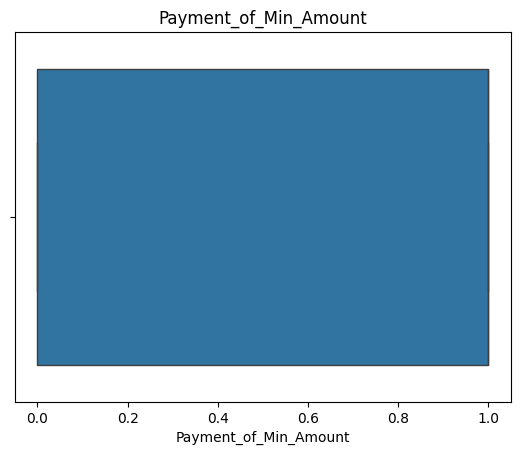

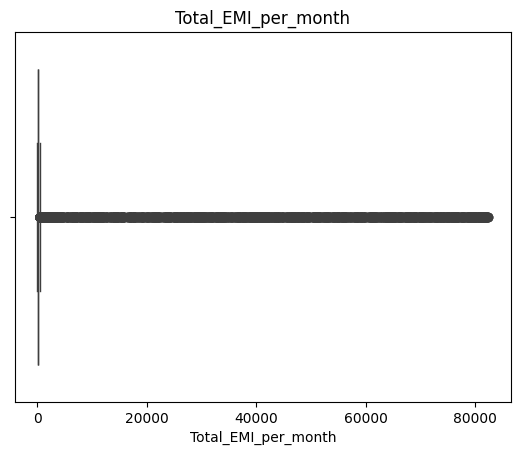

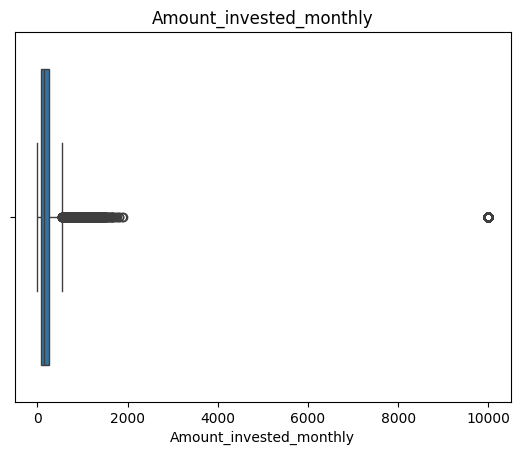

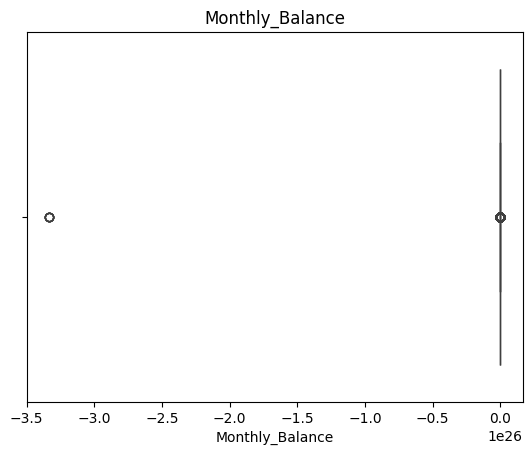

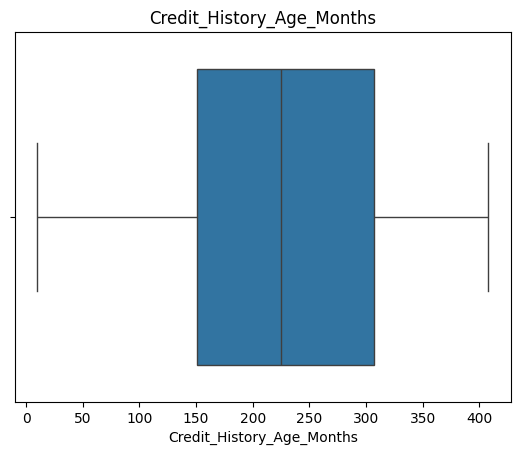

In [22]:
for column in df.select_dtypes(include=['float64', 'int64']):
    plt.figure()
    sns.boxplot(x=df[column])
    plt.title(column)
    plt.show()

Графики количества для категориальных столбцов

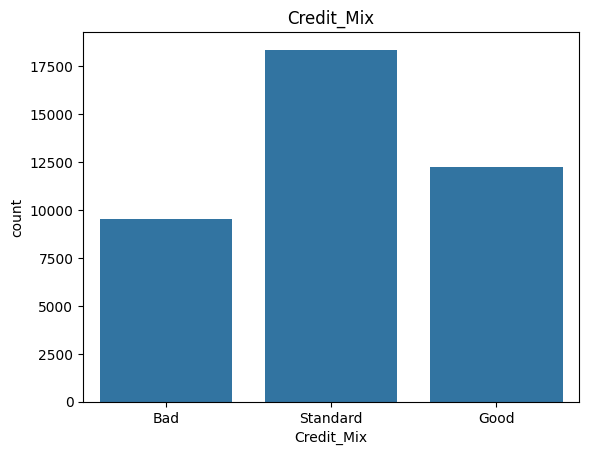

In [23]:
for column in df.select_dtypes(include=['category']):
    plt.figure()
    sns.countplot(x=df[column])
    plt.title(column)
    plt.show()

## Реализация Bagging и AdaBoost

In [24]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample, check_array
import numpy as np

class SimpleBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator=None, n_estimators=10):
        self.estimator = estimator if estimator is not None else DecisionTreeClassifier()
        self.n_estimators = n_estimators

    def fit(self, X, y):
        self.estimators_ = []
        for _ in range(self.n_estimators):
            estimator = self.estimator
            X_sample, y_sample = resample(X, y)
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)
        return self

    def predict(self, X):
        X = check_array(X)
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_])
        averaged_predictions = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=predictions)
        return averaged_predictions


class SimpleAdaBoostClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, estimator=None, n_estimators=50, learning_rate=1.0):
        self.estimator = estimator if estimator is not None else DecisionTreeClassifier(max_depth=1)
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate

    def fit(self, X, y):
        self.estimators_ = []
        self.alphas = []
        n_samples = X.shape[0]
        weights = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            estimator = self.estimator
            estimator.fit(X, y, sample_weight=weights)
            predictions = estimator.predict(X)
            incorrect = (predictions != y)
            estimator_error = np.mean(np.average(incorrect, weights=weights, axis=0))

            if estimator_error >= 1 - 1 / np.unique(y).size:
                break

            alpha = self.learning_rate * np.log((1 - estimator_error) / estimator_error)
            weights *= np.exp(alpha * incorrect * ((weights > 0) | (alpha < 0)))
            weights /= np.sum(weights)

            self.estimators_.append(estimator)
            self.alphas.append(alpha)

        return self

    def predict(self, X):
        X = check_array(X)
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_])
        weighted_predictions = np.dot(self.alphas, predictions)
        return np.sign(weighted_predictions)

## Обучение ансамблей с подбором гиперпараметров и кросс-валидацией

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
import time
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import optuna

encoder = LabelEncoder()
df['Credit_Mix'] = encoder.fit_transform(df['Credit_Mix'])
target = df['Credit_Mix'].copy()
df = df.drop(columns=['Credit_Mix'])
df = pd.get_dummies(df, drop_first=True)
df['Credit_Mix'] = target

imputer = SimpleImputer(strategy='mean')
X = df.drop(columns=['Credit_Mix'])
y = df['Credit_Mix']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)


def objective(trial, model_cls, init_params):
    model = model_cls(**init_params)
    if isinstance(model, HistGradientBoostingClassifier):
        params = {
          'max_depth': trial.suggest_int('max_depth', 1, 5),
          'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.03, log=True)
        }
    elif isinstance(model, cb.CatBoostClassifier):
      params = {
          "iterations": 1000,
          "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
          "depth": trial.suggest_int("depth", 1, 10),
          "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
          "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        }
    elif isinstance(model, RandomForestClassifier) or isinstance(model, GradientBoostingClassifier):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 1, 5),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10)
        }
    elif isinstance(model, lgb.LGBMClassifier):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 1, 5),
            'num_leaves': trial.suggest_int('num_leaves', 2, 2 ** trial.suggest_int('max_depth', 1, 5)),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.03, log=True)
        }
    elif isinstance(model, xgb.XGBClassifier):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 1, 5),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        }
    else:
      params = {
          'n_estimators': trial.suggest_int('n_estimators', 50, 200)
        }
    model.set_params(**params)
    model.fit(X_train_imputed, y_train)
    scores = cross_val_score(model, X_train_imputed, y_train, cv=5, scoring='accuracy')
    return scores.mean()


models = [
    (BaggingClassifier, {'estimator': DecisionTreeClassifier(max_depth=1)}),
    (AdaBoostClassifier, {'estimator': DecisionTreeClassifier(max_depth=1)}),
    (RandomForestClassifier, {}),
    (GradientBoostingClassifier, {}),
    (HistGradientBoostingClassifier, {}),
    (xgb.XGBClassifier, {}),
    (lgb.LGBMClassifier, {'force_col_wise': True}),
    (cb.CatBoostClassifier, {'silent': True}),
    (SimpleBaggingClassifier, {'estimator': DecisionTreeClassifier(max_depth=1)}),
    (SimpleAdaBoostClassifier, {'estimator': DecisionTreeClassifier(max_depth=1)}),
]


results = []

for model_cls, init_params in models:
    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, model_cls, init_params), n_trials=5)
    best_params = study.best_params

    start_time = time.time()
    best_model = model_cls(**init_params, **best_params)
    best_model.fit(X_train_imputed, y_train)
    fit_time = time.time() - start_time

    y_pred = best_model.predict(X_test_imputed)
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results.append({
        'Model': model_cls.__name__,
        'Fit Time': fit_time,
        'Accuracy': accuracy,
        'Confusion Matrix': conf_matrix
    })


for result in results:
    print(f"Model: {result['Model']}")
    print(f"Fit Time: {result['Fit Time']:.4f} seconds")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print("Confusion Matrix:")
    print(result['Confusion Matrix'])


[I 2024-04-15 12:30:30,284] A new study created in memory with name: no-name-921eae12-786a-4c40-b6c6-78627ce5e2cc
[I 2024-04-15 12:31:13,316] Trial 0 finished with value: 0.5122571428571427 and parameters: {'n_estimators': 163}. Best is trial 0 with value: 0.5122571428571427.
[I 2024-04-15 12:31:50,062] Trial 1 finished with value: 0.5122571428571427 and parameters: {'n_estimators': 165}. Best is trial 0 with value: 0.5122571428571427.
[I 2024-04-15 12:32:03,063] Trial 2 finished with value: 0.5122571428571427 and parameters: {'n_estimators': 58}. Best is trial 0 with value: 0.5122571428571427.
[I 2024-04-15 12:32:22,254] Trial 3 finished with value: 0.5122571428571427 and parameters: {'n_estimators': 85}. Best is trial 0 with value: 0.5122571428571427.
[I 2024-04-15 12:32:35,638] Trial 4 finished with value: 0.5122571428571427 and parameters: {'n_estimators': 55}. Best is trial 0 with value: 0.5122571428571427.
[I 2024-04-15 12:32:43,127] A new study created in memory with name: no-na

[LightGBM] [Info] Total Bins 3954
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 19
[LightGBM] [Info] Start training from score -1.659679
[LightGBM] [Info] Start training from score -1.411641
[LightGBM] [Info] Start training from score -0.996649
[LightGBM] [Info] Start training from score -1.624842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2024-04-15 13:20:29,901] Trial 0 finished with value: 0.7460571428571428 and parameters: {'n_estimators': 77, 'max_depth': 5, 'num_leaves': 24, 'learning_rate': 0.017301894274313022}. Best is trial 0 with value: 0.7460571428571428.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total B

[I 2024-04-15 13:20:40,285] Trial 1 finished with value: 0.7252285714285714 and parameters: {'n_estimators': 199, 'max_depth': 1, 'num_leaves': 2, 'learning_rate': 0.026556214363510213}. Best is trial 0 with value: 0.7460571428571428.


[LightGBM] [Info] Total Bins 3954
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 19
[LightGBM] [Info] Start training from score -1.659679
[LightGBM] [Info] Start training from score -1.411641
[LightGBM] [Info] Start training from score -0.996649
[LightGBM] [Info] Start training from score -1.624842
[LightGBM] [Info] Total Bins 3934
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 19
[LightGBM] [Info] Start training from score -1.659604
[LightGBM] [Info] Start training from score -1.411759
[LightGBM] [Info] Start training from score -0.996668
[LightGBM] [Info] Start training from score -1.624733
[LightGBM] [Info] Total Bins 3788
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 19
[LightGBM] [Info] Start training from score -1.659792
[LightGBM] [Info] Start training from score -1.411612
[LightGBM] [Info] Start training from score -0.996668
[LightGBM] [Info] Start t

[I 2024-04-15 13:20:44,100] Trial 2 finished with value: 0.7028 and parameters: {'n_estimators': 56, 'max_depth': 2, 'num_leaves': 3, 'learning_rate': 0.013258522010846884}. Best is trial 0 with value: 0.7460571428571428.


[LightGBM] [Info] Total Bins 3954
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 19
[LightGBM] [Info] Start training from score -1.659679
[LightGBM] [Info] Start training from score -1.411641
[LightGBM] [Info] Start training from score -0.996649
[LightGBM] [Info] Start training from score -1.624842
[LightGBM] [Info] Total Bins 3934
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 19
[LightGBM] [Info] Start training from score -1.659604
[LightGBM] [Info] Start training from score -1.411759
[LightGBM] [Info] Start training from score -0.996668
[LightGBM] [Info] Start training from score -1.624733
[LightGBM] [Info] Total Bins 3788
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 19
[LightGBM] [Info] Start training from score -1.659792
[LightGBM] [Info] Start training from score -1.411612
[LightGBM] [Info] Start training from score -0.996668
[LightGBM] [Info] Start t

[I 2024-04-15 13:20:50,259] Trial 3 finished with value: 0.7145142857142857 and parameters: {'n_estimators': 127, 'max_depth': 3, 'num_leaves': 2, 'learning_rate': 0.020556981818036828}. Best is trial 0 with value: 0.7460571428571428.


[LightGBM] [Info] Total Bins 3954
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 19
[LightGBM] [Info] Start training from score -1.659679
[LightGBM] [Info] Start training from score -1.411641
[LightGBM] [Info] Start training from score -0.996649
[LightGBM] [Info] Start training from score -1.624842
[LightGBM] [Info] Total Bins 3934
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 19
[LightGBM] [Info] Start training from score -1.659604
[LightGBM] [Info] Start training from score -1.411759
[LightGBM] [Info] Start training from score -0.996668
[LightGBM] [Info] Start training from score -1.624733
[LightGBM] [Info] Total Bins 3788
[LightGBM] [Info] Number of data points in the train set: 28000, number of used features: 19
[LightGBM] [Info] Start training from score -1.659792
[LightGBM] [Info] Start training from score -1.411612
[LightGBM] [Info] Start training from score -0.996668
[LightGBM] [Info] Start t

[I 2024-04-15 13:21:07,323] Trial 4 finished with value: 0.748257142857143 and parameters: {'n_estimators': 172, 'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.014926795612362952}. Best is trial 4 with value: 0.748257142857143.


[LightGBM] [Info] Total Bins 3954
[LightGBM] [Info] Number of data points in the train set: 35000, number of used features: 19
[LightGBM] [Info] Start training from score -1.659679
[LightGBM] [Info] Start training from score -1.411641
[LightGBM] [Info] Start training from score -0.996649
[LightGBM] [Info] Start training from score -1.624842


[I 2024-04-15 13:21:10,430] A new study created in memory with name: no-name-0ccaee7a-21a2-4ad6-ab69-dfcd56cec81d
[I 2024-04-15 13:27:28,796] Trial 0 finished with value: 0.7454571428571428 and parameters: {'learning_rate': 0.0019819157123761085, 'depth': 8, 'colsample_bylevel': 0.6128053735827792, 'min_data_in_leaf': 23}. Best is trial 0 with value: 0.7454571428571428.
[I 2024-04-15 13:28:27,710] Trial 1 finished with value: 0.7456285714285714 and parameters: {'learning_rate': 0.08702157998921561, 'depth': 1, 'colsample_bylevel': 0.3336969986096065, 'min_data_in_leaf': 89}. Best is trial 1 with value: 0.7456285714285714.
[I 2024-04-15 13:31:52,969] Trial 2 finished with value: 0.7538857142857143 and parameters: {'learning_rate': 0.052884628040763264, 'depth': 6, 'colsample_bylevel': 0.5519962066998153, 'min_data_in_leaf': 20}. Best is trial 2 with value: 0.7538857142857143.
[I 2024-04-15 13:33:52,119] Trial 3 finished with value: 0.747 and parameters: {'learning_rate': 0.0070950110485

Model: BaggingClassifier
Fit Time: 7.2495 seconds
Accuracy: 0.5135
Confusion Matrix:
[[   0    0 2899    0]
 [   0 3275  454    0]
 [   0 1033 4427    0]
 [   0 1067 1845    0]]
Model: AdaBoostClassifier
Fit Time: 5.1362 seconds
Accuracy: 0.5511
Confusion Matrix:
[[2791    0   21   87]
 [   0 3721    2    6]
 [ 442 1679 1169 2170]
 [ 744 1322  260  586]]
Model: RandomForestClassifier
Fit Time: 5.7659 seconds
Accuracy: 0.7455
Confusion Matrix:
[[2742    0  157    0]
 [   0 3506  223    0]
 [ 233  292 4935    0]
 [ 671  897 1344    0]]
Model: GradientBoostingClassifier
Fit Time: 179.3481 seconds
Accuracy: 0.7588
Confusion Matrix:
[[2763    0   88   48]
 [   0 3466  213   50]
 [ 135  171 5110   44]
 [ 648  859 1362   43]]
Model: HistGradientBoostingClassifier
Fit Time: 2.7025 seconds
Accuracy: 0.7536
Confusion Matrix:
[[2819    0   76    4]
 [   0 3500  229    0]
 [ 246  228 4984    2]
 [ 691  880 1340    1]]
Model: XGBClassifier
Fit Time: 1.7388 seconds
Accuracy: 0.7579
Confusion Matrix:

## Графики сравния качества моделей

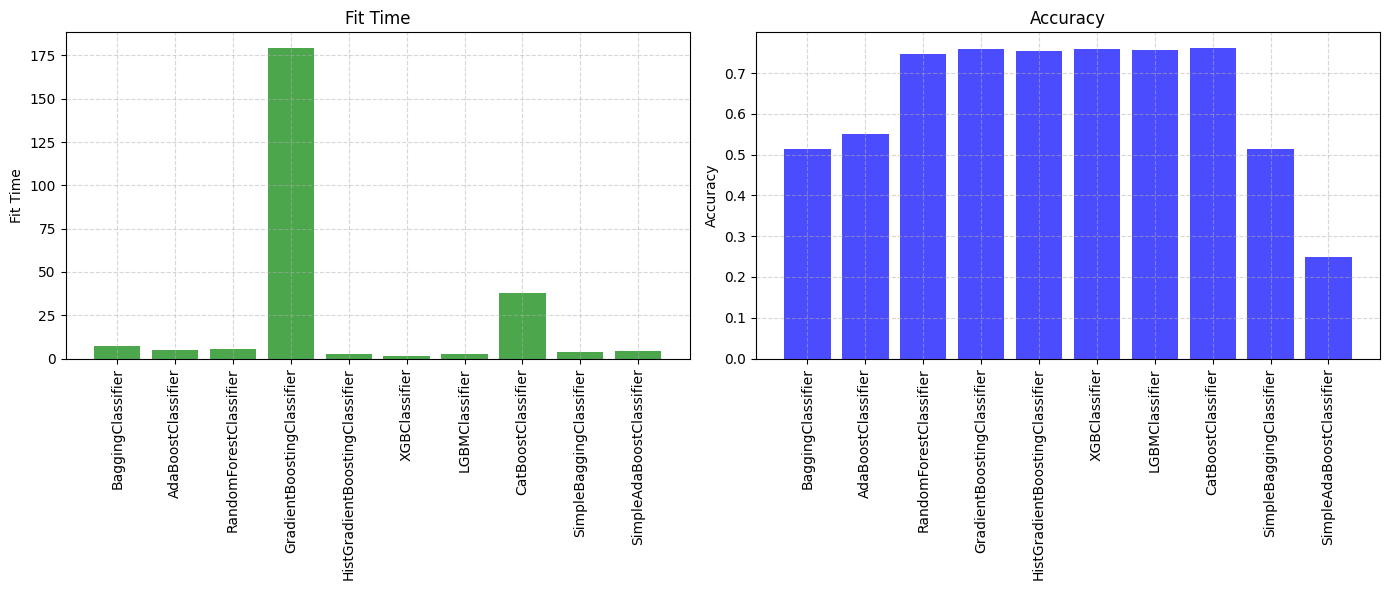

In [33]:
import matplotlib.pyplot as plt
import numpy as np

model_names = [r['Model'] for r in results]
fit_times = [r['Fit Time'] for r in results]
accuracies = [r['Accuracy'] for r in results]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

bars1 = ax1.bar(model_names, fit_times, color='green', alpha=0.7)
ax1.set_title('Fit Time')
ax1.set_ylabel('Fit Time')
ax1.tick_params(axis='x', rotation=90)
ax1.grid(True, linestyle='--', alpha=0.5)

bars2 = ax2.bar(model_names, accuracies, color='blue', alpha=0.7)
ax2.set_title('Accuracy')
ax2.set_ylabel('Accuracy')
ax2.tick_params(axis='x', rotation=90)
ax2.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

plt.show()
